# Customer Segmentation

Kumpulan data mencakup penjualan tahunan ke pelanggan oleh distributor. Variabel 'Saluran' dan 'Wilayah' bersifat kategoris, yang menunjukkan dari saluran dan wilayah mana pembelian dilakukan.

🎯 Tujuan kami adalah menggunakan pembelajaran tanpa pengawasan, khususnya analisis pengelompokan, untuk membagi pelanggan ke dalam segmen yang berbeda. Hal ini bertujuan untuk membantu distributor mendapatkan wawasan tentang profil pelanggan.

In [5]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#from minisom import MiniSom
from tabulate import tabulate
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree, cophenet
from scipy.stats import skew, kurtosis, normaltest, shapiro, probplot, boxcox 

In [6]:
data = pd.read_csv('Wholesale customers data.csv')
df = data.copy()
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


<div style="float: left;">

| Variable              | Description                                 |
|-----------------------|---------------------------------------------|
| FRESH                 | Annual spending on fresh products           | 
| MILK                  | Annual spending on milk products            | 
| GROCERY               | Annual spending on grocery products         | 
| FROZEN               | Annual spending on frozen products          | 
| DETERGENT/PAPER       | Annual spending on detergent and paper products | 
| DELICATESSEN          | Annual spending on delicatessen products    |

Karena 'Region' dan 'Channel' merupakan variabel kategori, kami tidak akan memasukkannya ke dalam analisis.

In [7]:
df.shape

(440, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


Dari statistik deskriptif terlihat bahwa standar deviasi data cukup tinggi dan data tidak berdistribusi normal.

In [10]:
corr = df.corr()
corr

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


# 📊 EDA 

## Categorical Data

### Channel Variable
Variabel 'Channel' menunjukkan melalui Channel mana pelanggan melakukan pembelian, yang dapat berupa Hotel/Restoran/Kafe atau Ritel. Tipe variabelnya adalah kategorikal.

Ada 2 nilai unikChannelan yang diberi kode dengan bobot **1** adalah yang dominan. Dapat dicatat bahwa distribusinya tidak seimbang.


In [12]:
df['Channel'].unique()

array([2, 1], dtype=int64)

Channel
1    298
2    142
Name: count, dtype: int64

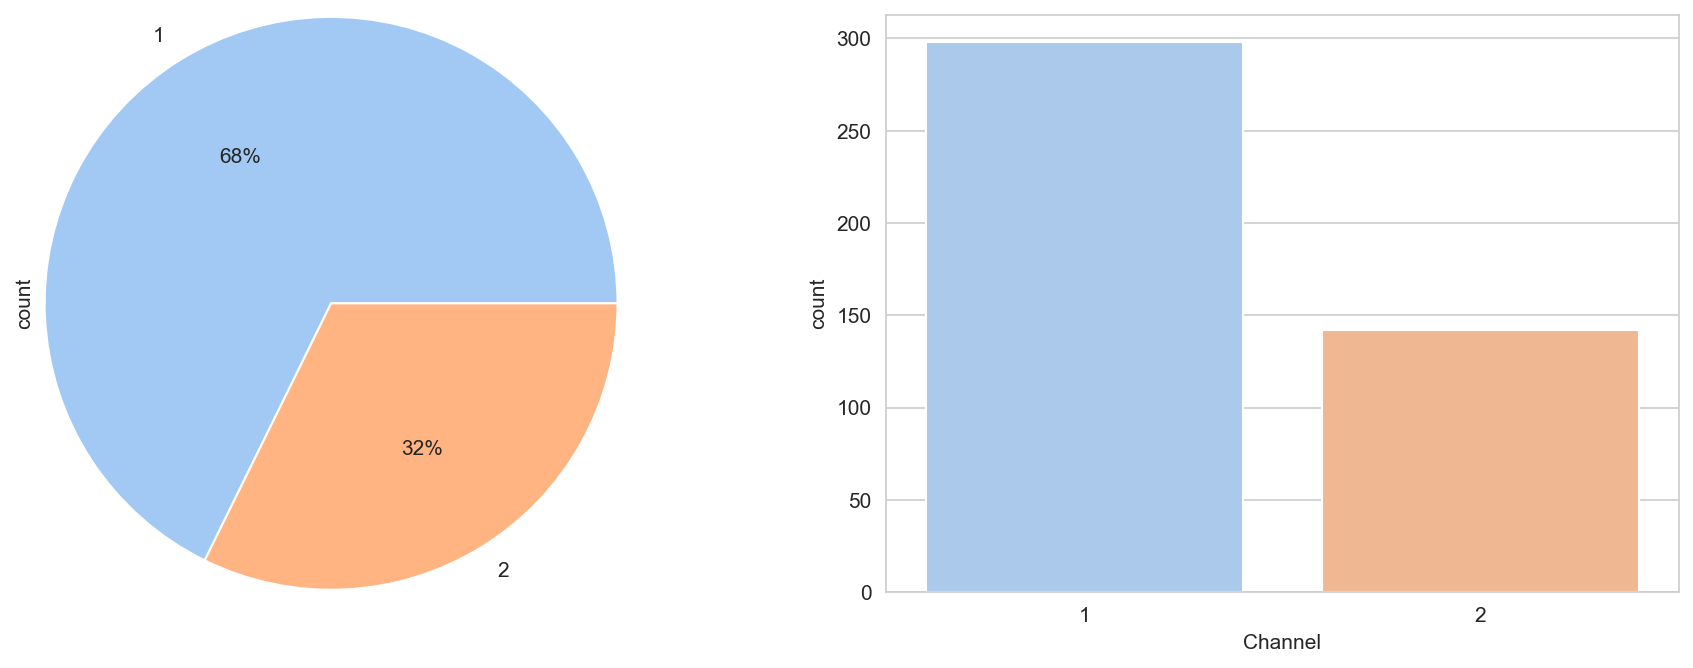

In [13]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 5), dpi=150)
plt.subplot(121)
df['Channel'].value_counts().plot(kind='pie', autopct='%2.f%%', radius=1.24, colors=sns.color_palette('pastel'))
plt.subplot(122)
sns.countplot(data=df, x='Channel', palette='pastel')
df['Channel'].value_counts()

### Region Variable
Variabel 'Region' menunjukkan dari wilayah mana pelanggan melakukan pembelian, yaitu Istanbul/Izmir/Ankara. Tipe variabelnya adalah kategorikal.

Ada 3 nilai unik. Wilayah yang diberi kode bobot **3** merupakan wilayah yang dominan. Ketidakseimbangan disini lebih besar dibandingkan dengan variabel Channel.

In [14]:
df['Region'].unique()

array([3, 1, 2], dtype=int64)

Region
3    316
1     77
2     47
Name: count, dtype: int64

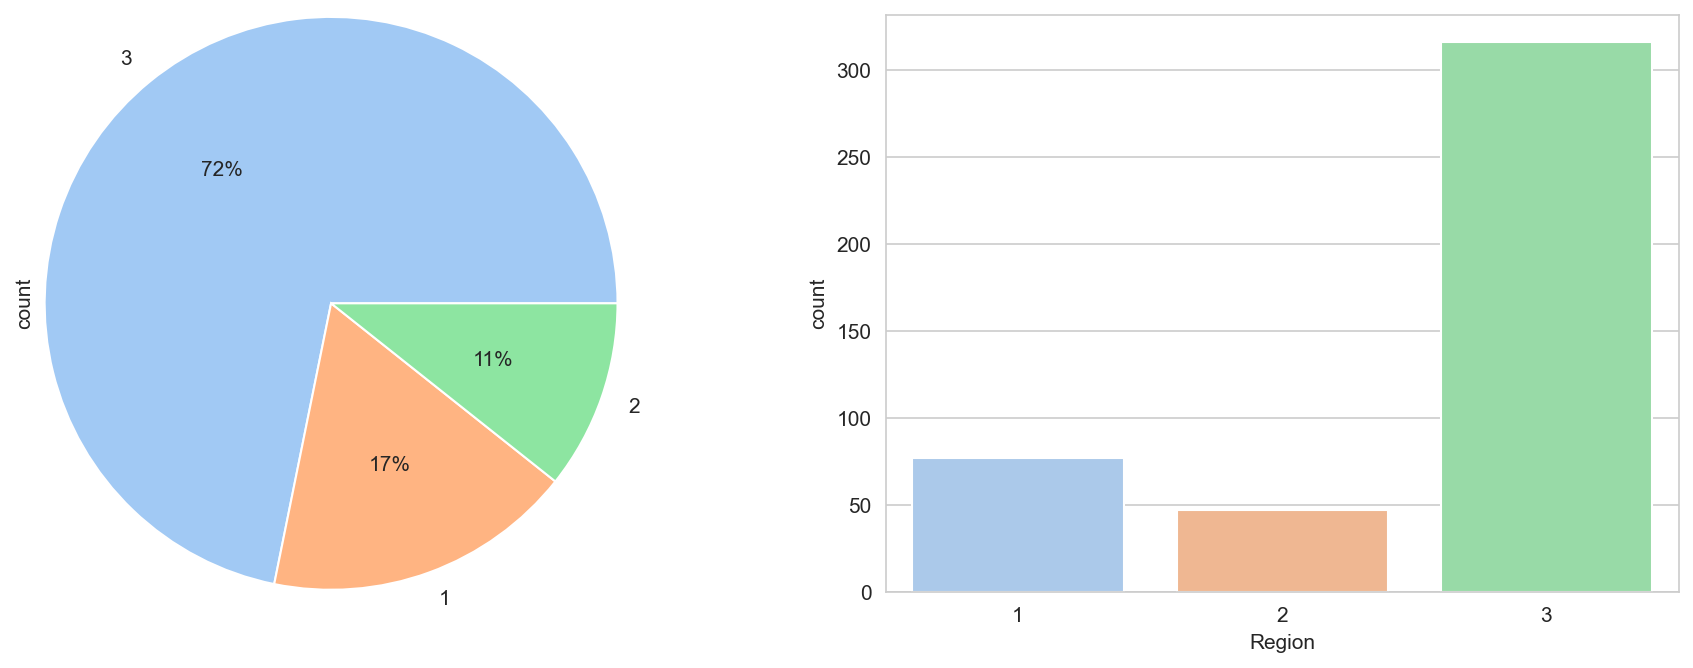

In [15]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 5), dpi=150)
plt.subplot(121)
df['Region'].value_counts().plot(kind='pie', autopct='%2.f%%', radius=1.24, colors=sns.color_palette('pastel'))
plt.subplot(122)
sns.countplot(data=df, x='Region', palette='pastel')
df['Region'].value_counts()

## Numerical Variables

In [16]:
# Drop categorical variables
df.drop(['Region', 'Channel'], axis=1, inplace=True)

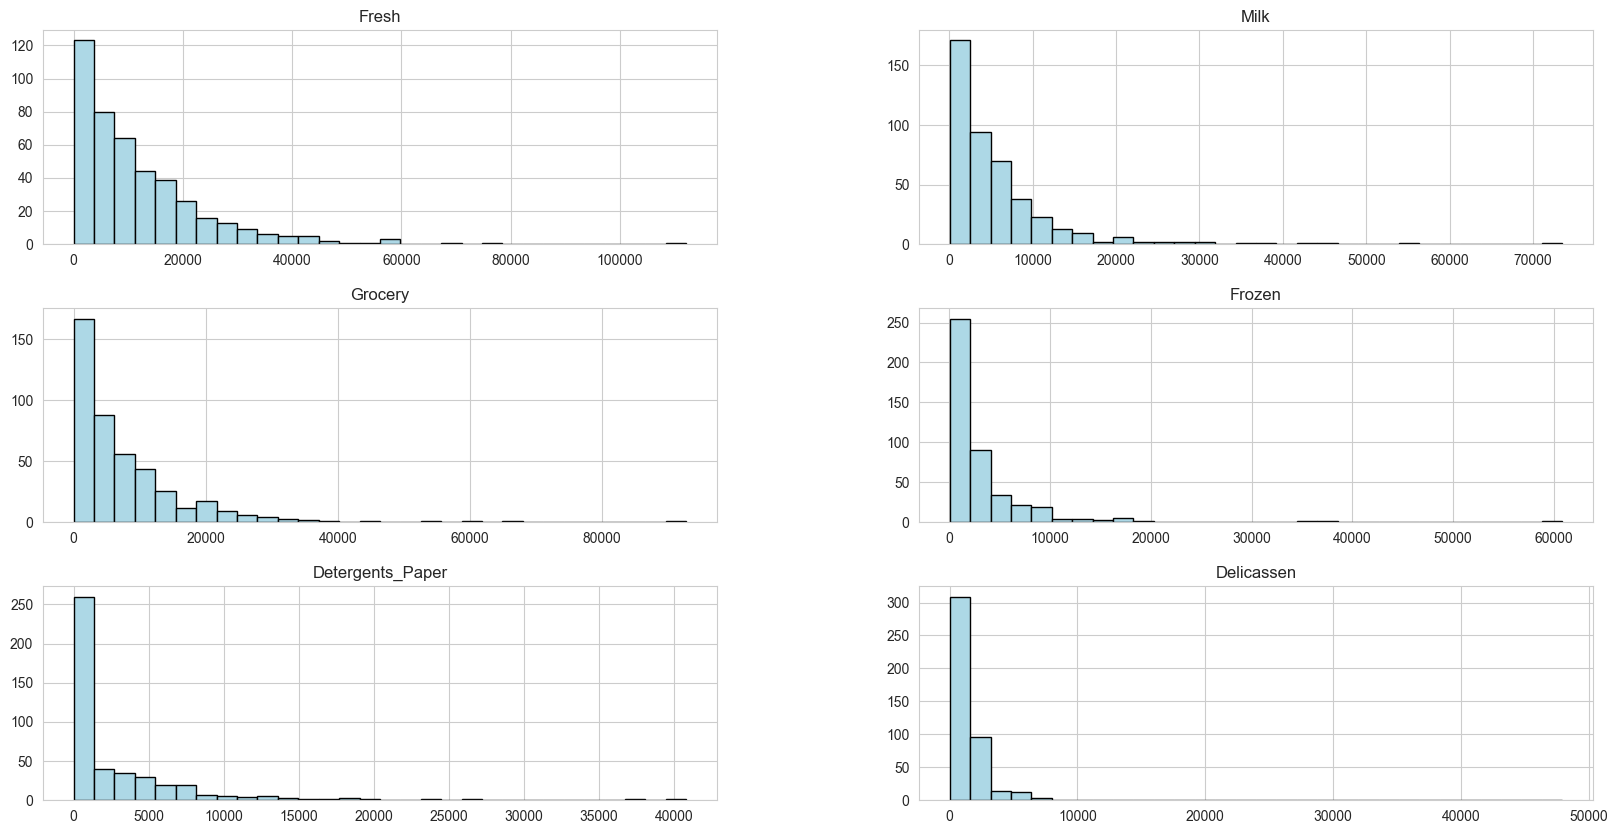

In [17]:
df.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

**From this output, we can infer that the distributions of variables are highly skewed, and there may be outliers.**

## Skewness and Kurtosis

In [19]:
skewness = df.skew()
kurtosisness = df.kurtosis()

headers = ['Variable', 'Shapiro Test', 'Skewness Coefficient', 'Skewness', 'Kurtosis Coefficient', 'Kurtosis']

table_data = []
for col in df.columns:
    stat, p = normaltest(df[col])
    normal_dist = 'Yes' if p >= 0.05 else 'No'
    skewness_val = f'{skewness[col]:.4f}'
    skewness_desc = 'Highly skewed' if skewness[col] < -1 or skewness[col] > 1 else 'Symmetric or mildly skewed'
    kurtosis_val = f'{kurtosisness[col]:.4f}'
    kurtosis_desc = 'Very flat or sharp' if kurtosisness[col] < -2 or kurtosisness[col] > 2 else 'Normal or mildly flat'

    stat_sh, p_sh = shapiro(df[col])
    shapiro_test = 'Yes' if p_sh >= 0.05 else 'No'
    
    table_data.append([col, shapiro_test, skewness_val, skewness_desc, kurtosis_val, kurtosis_desc])

table = tabulate(table_data, headers, tablefmt='pretty')
print(table)


+------------------+--------------+----------------------+---------------+----------------------+--------------------+
|     Variable     | Shapiro Test | Skewness Coefficient |   Skewness    | Kurtosis Coefficient |      Kurtosis      |
+------------------+--------------+----------------------+---------------+----------------------+--------------------+
|      Fresh       |      No      |        2.5613        | Highly skewed |       11.5364        | Very flat or sharp |
|       Milk       |      No      |        4.0538        | Highly skewed |       24.6694        | Very flat or sharp |
|     Grocery      |      No      |        3.5874        | Highly skewed |       20.9147        | Very flat or sharp |
|      Frozen      |      No      |        5.9080        | Highly skewed |       54.6893        | Very flat or sharp |
| Detergents_Paper |      No      |        3.6319        | Highly skewed |       19.0095        | Very flat or sharp |
|    Delicassen    |      No      |       11.151

In [20]:
normality=pd.DataFrame(index=['p-value', 'test-statistic'])
for i in df.columns:
    normality[i]=shapiro(df[i])
    
normality.T  

,p-value,test-statistic
Fresh,0.781436,7.918344e-24
Milk,0.628334,9.762267e-30
Grocery,0.676230,3.906112e-28
Frozen,0.528297,1.291356e-32
Detergents_Paper,0.605482,1.914582e-30
Delicassen,0.361068,1.753416e-36


Distribusinya sangat miring dan datar. Jika kita melakukan pengelompokan dalam keadaan ini, nilai-nilai yang miring dalam variabel dapat menyebabkan hasil pengukuran jarak yang ekstrim. Untuk menghindari hal ini, kami akan mengambil logaritma datanya. Proses ini dapat membuat distribusi data menjadi lebih simetris dan meningkatkan hasil clustering.

Hal-hal yang perlu diperhatikan sebelum menerapkan transformasi logaritma:
1. Transformasi logaritmik sangat efektif untuk data yang condong ke kanan.
2. Tidak boleh ada nilai nol atau negatif dalam kumpulan data.
3. Hasil yang lebih seimbang dapat diperoleh bila variabel-variabel dalam kumpulan data mempunyai kepentingan yang sama.

In [21]:
# log transform
df = np.log(df)

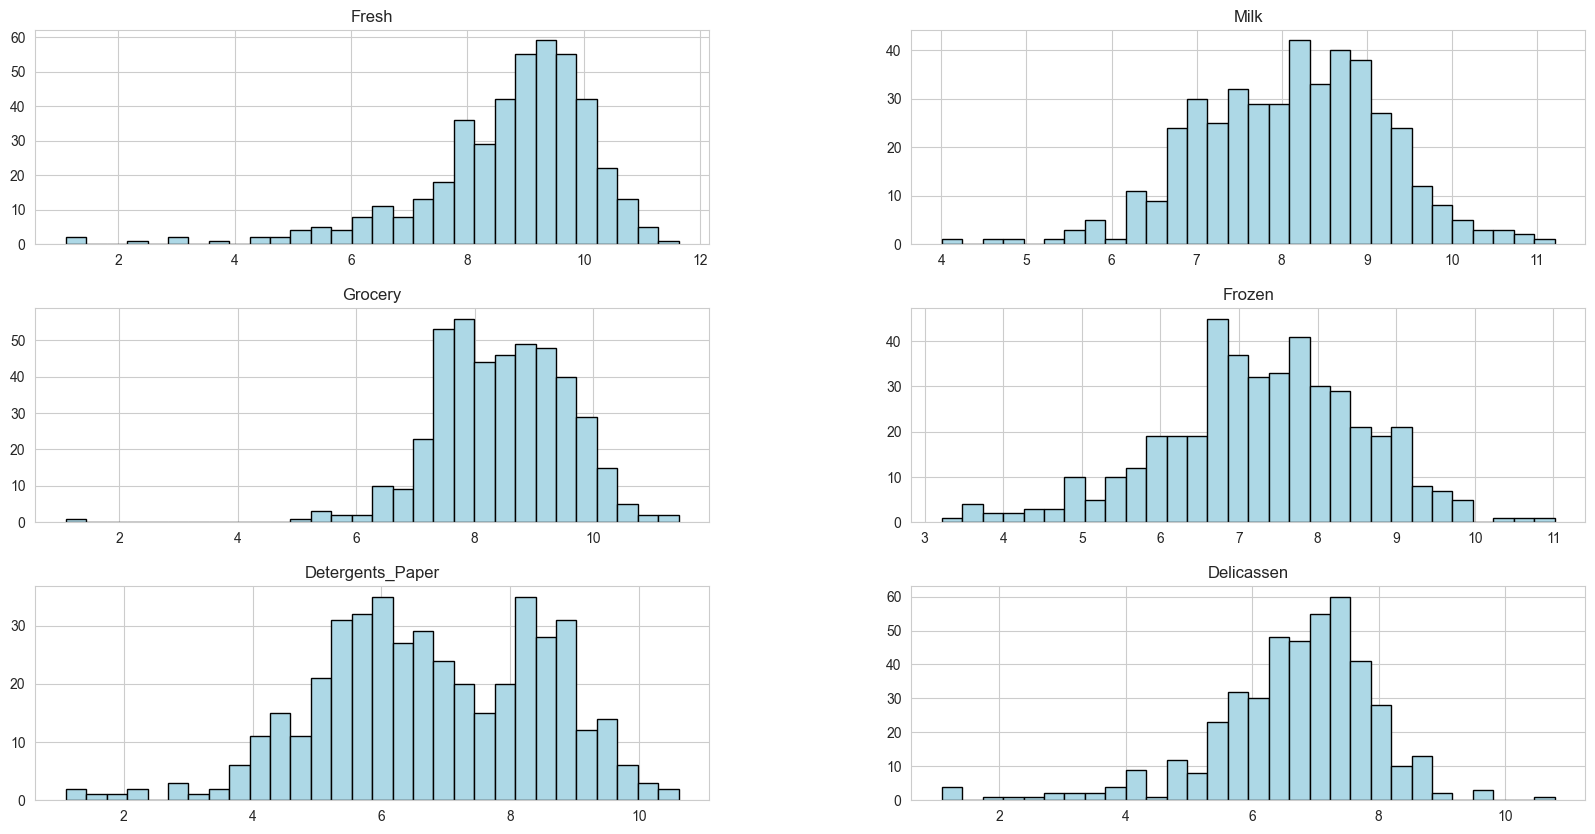

In [22]:
df.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

**After the transformation, we can observe that the data has become more balanced.**

## Normal Distribution Check

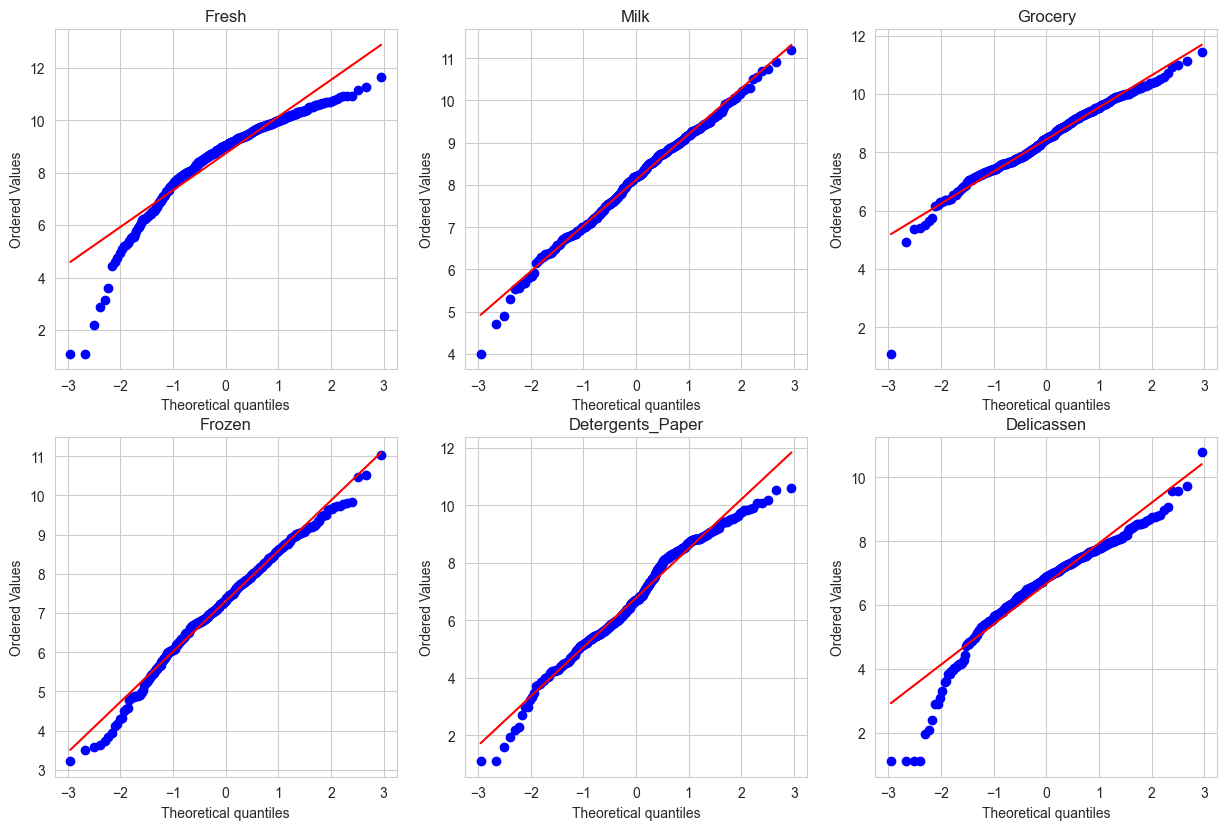

In [23]:
plt.figure(figsize=(15,15))
for i,var in enumerate(df.columns):
    plt.subplot(3,3,i+1)
    probplot(df[var], plot=plt)
    plt.title(f'{var}')
plt.show()  

**The variables have generally captured a normal distribution. From this output, we can sense that there may be outliers in the dataset.**

## Variability


<Axes: >

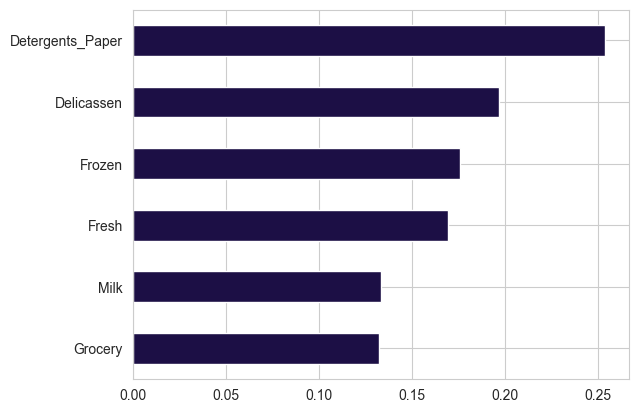

In [25]:
variability_coefficient = df.std() / df.mean()
sorted_vc = variability_coefficient.sort_values()
sorted_vc.plot.barh(x='Variables', y='Variability Coefficient', color='#1c0f45')

**Detergents_Paper has exhibited a wider variation compared to the others.**


## Box Plots

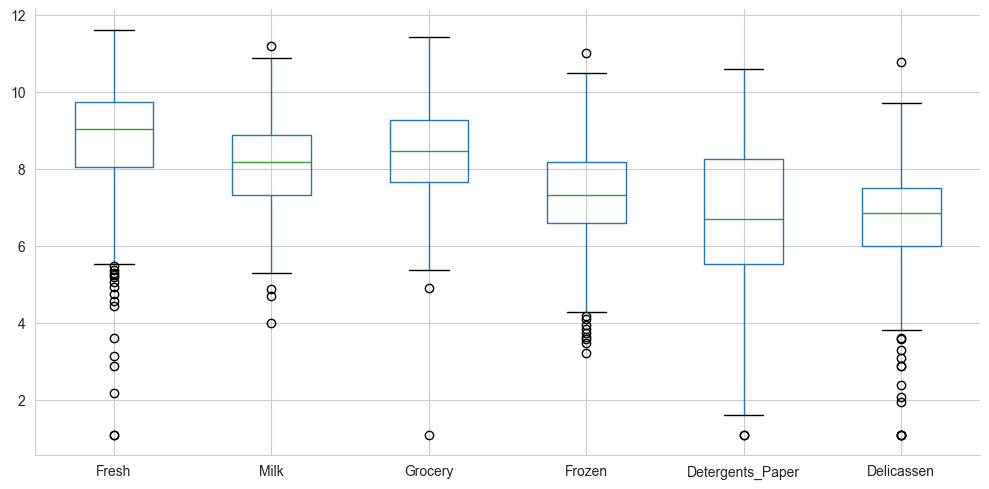

In [26]:
plt.figure(figsize=(10, 5))
df.boxplot()
sns.despine()
plt.tight_layout()
plt.show()

**Particularly, outliers in the 'Fresh' and 'Delicassen' variables are noteworthy.**

## Correlation

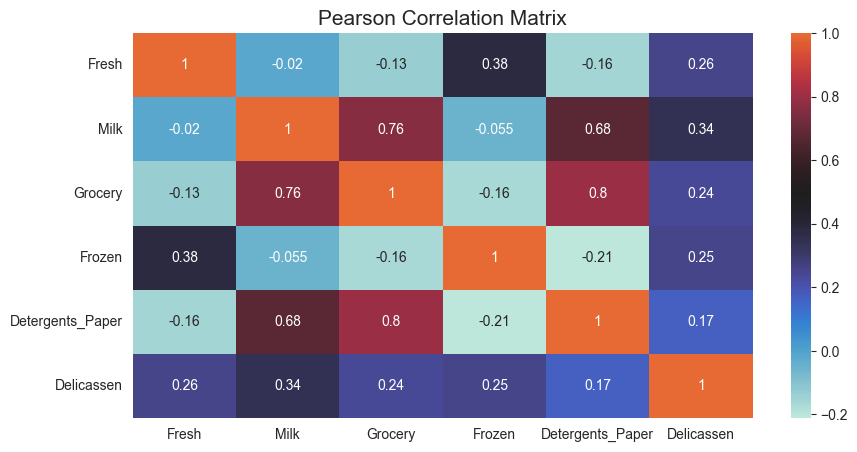

In [27]:
corr=df.corr()
plt.figure(figsize=(10,5))
plt.title('Pearson Correlation Matrix',fontsize=15)
sns.heatmap(corr, center=0.5,annot=True)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

**'Grocery', 'Detergents_Paper', and 'Milk' have shown high correlation.**

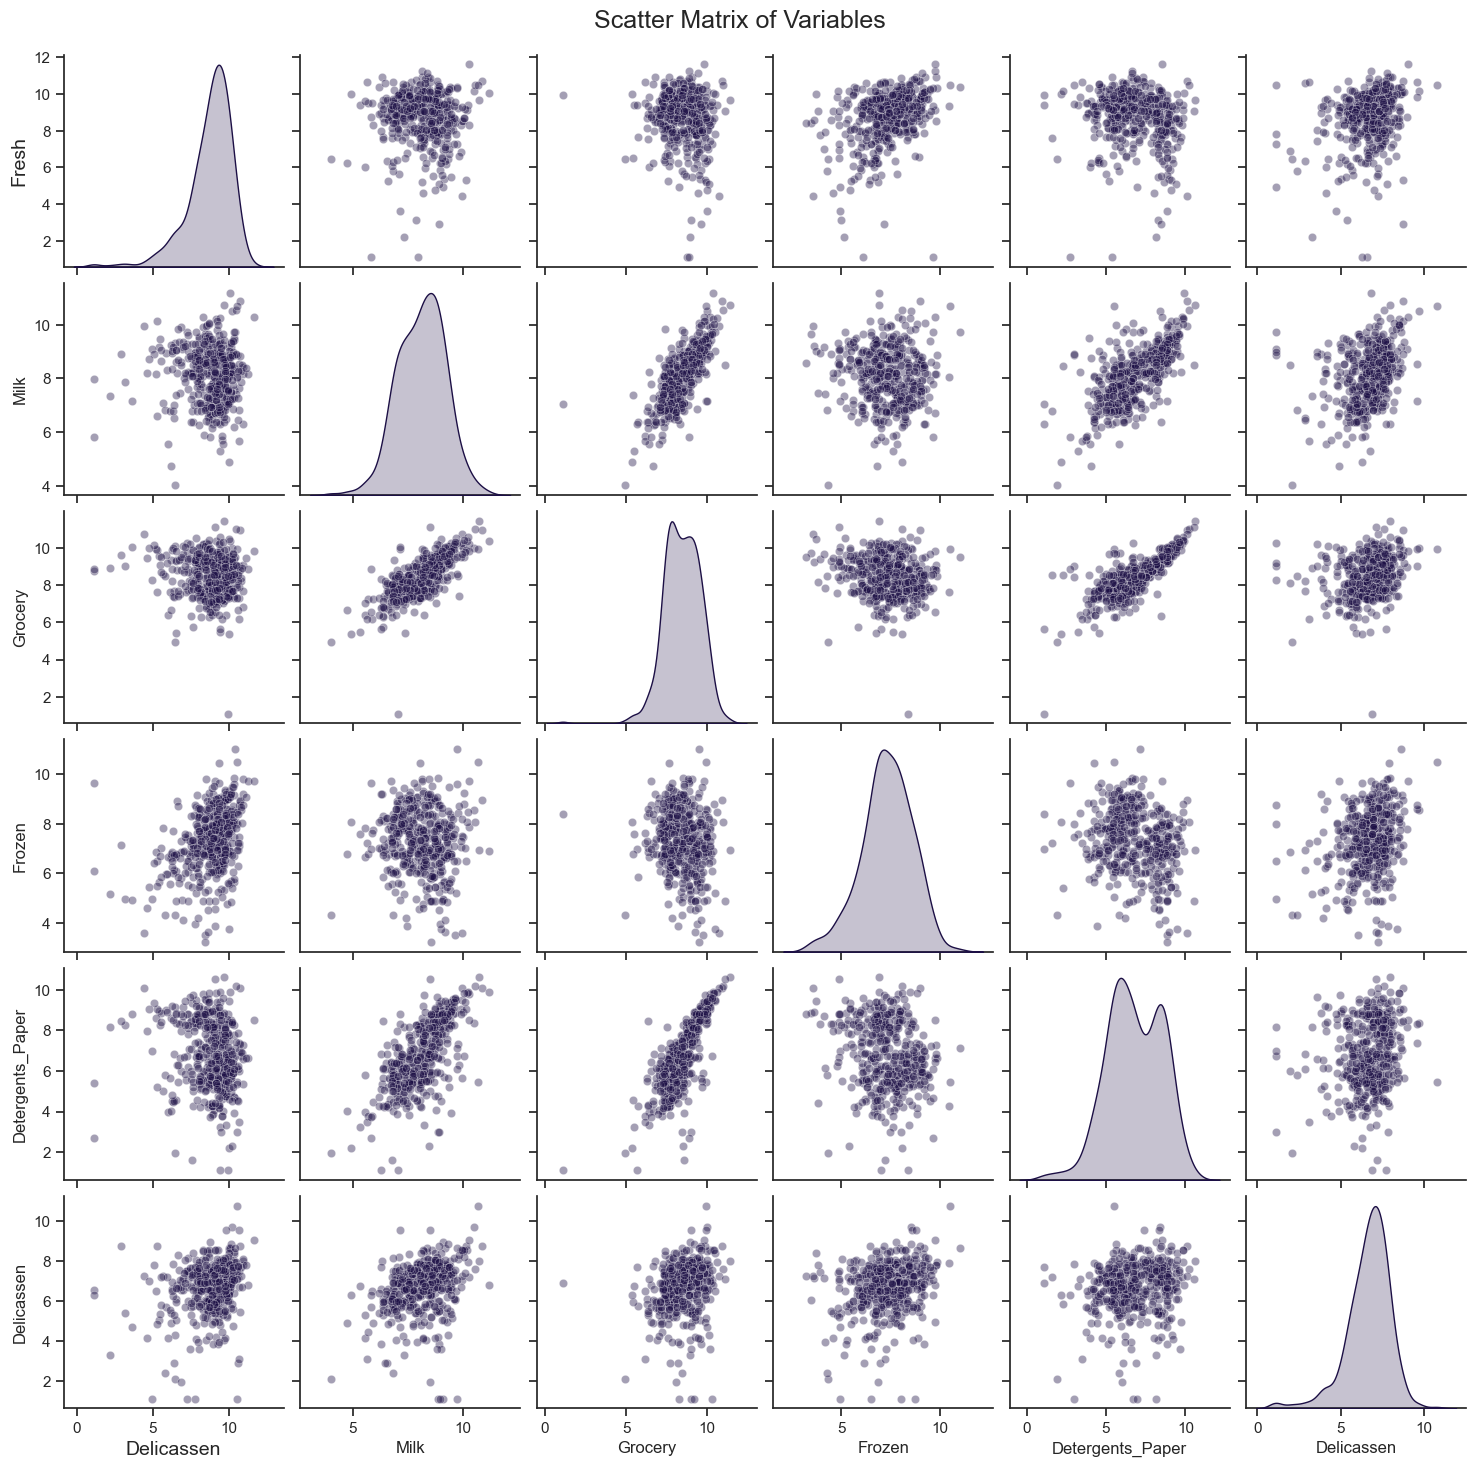

In [28]:
custom_palette = sns.color_palette(['#1c0f45'])
sns.set(style='ticks', palette=custom_palette) 
scatter_matrix = sns.pairplot(df, diag_kind='kde', markers='o', plot_kws={'alpha': 0.4})
plt.subplots_adjust(top=0.95)  
scatter_matrix.fig.suptitle('Scatter Matrix of Variables', fontsize=18)  
scatter_matrix.axes[0, 0].set_ylabel(df.columns[0], fontsize=14)  
scatter_matrix.axes[-1, 0].set_xlabel(df.columns[-1], fontsize=14)  
plt.show()

# 💹 Data Preprocessing

### Outlier Analysis

Mari kita identifikasi outlier dan gunakan metode pembatasan untuk menyamakan nilai-nilai ini ke batas bawah dan batas atas.

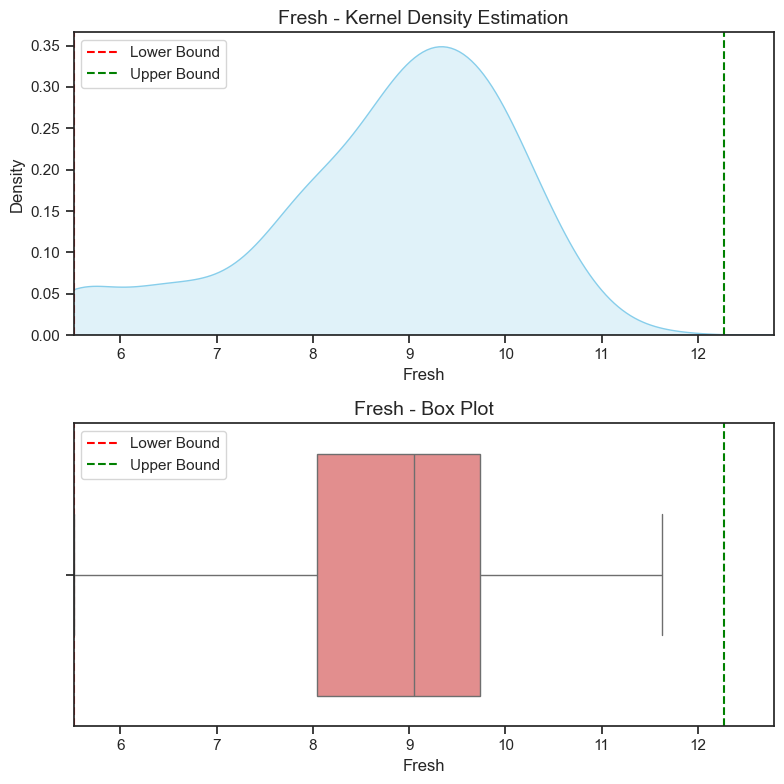

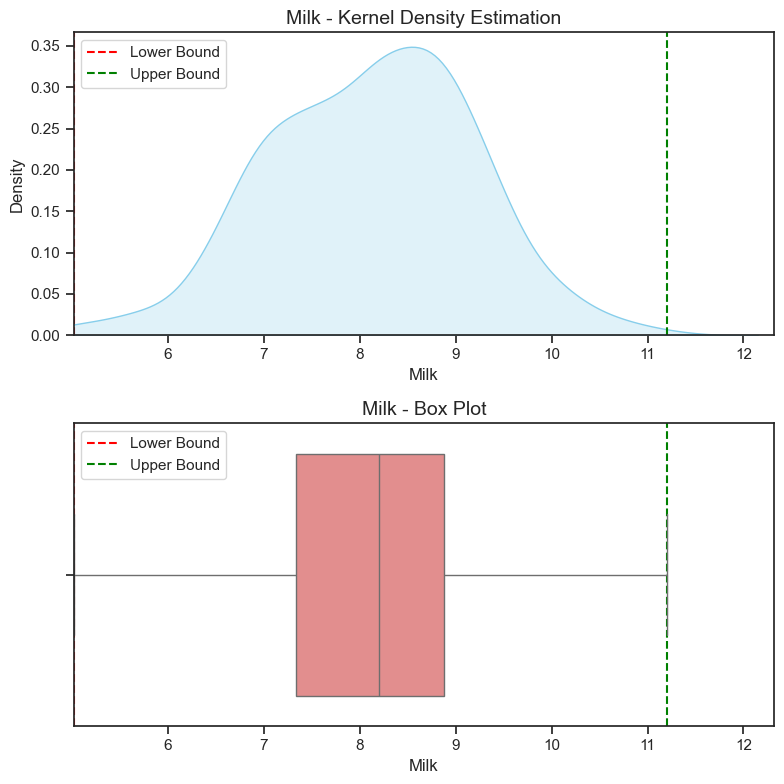

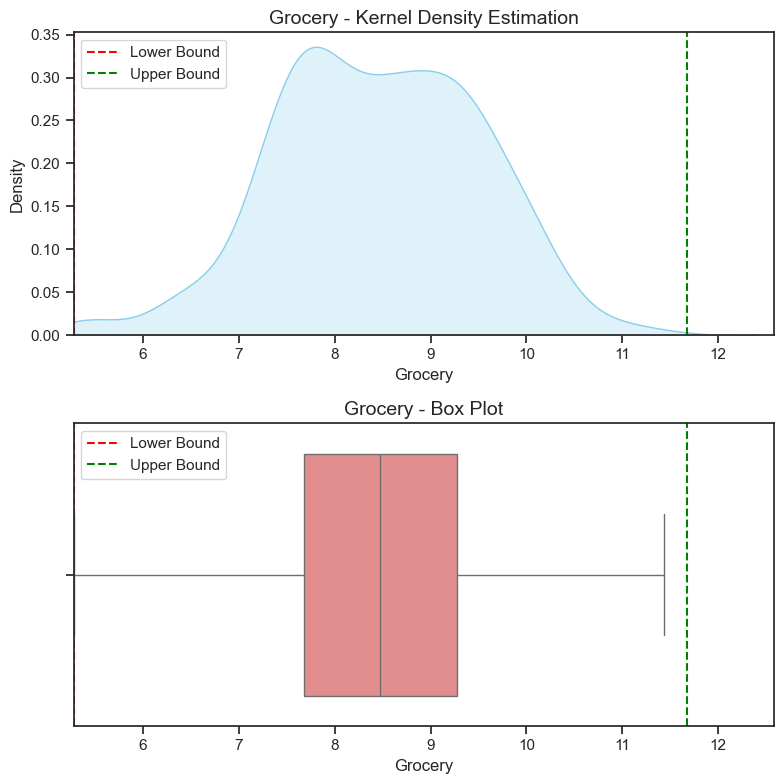

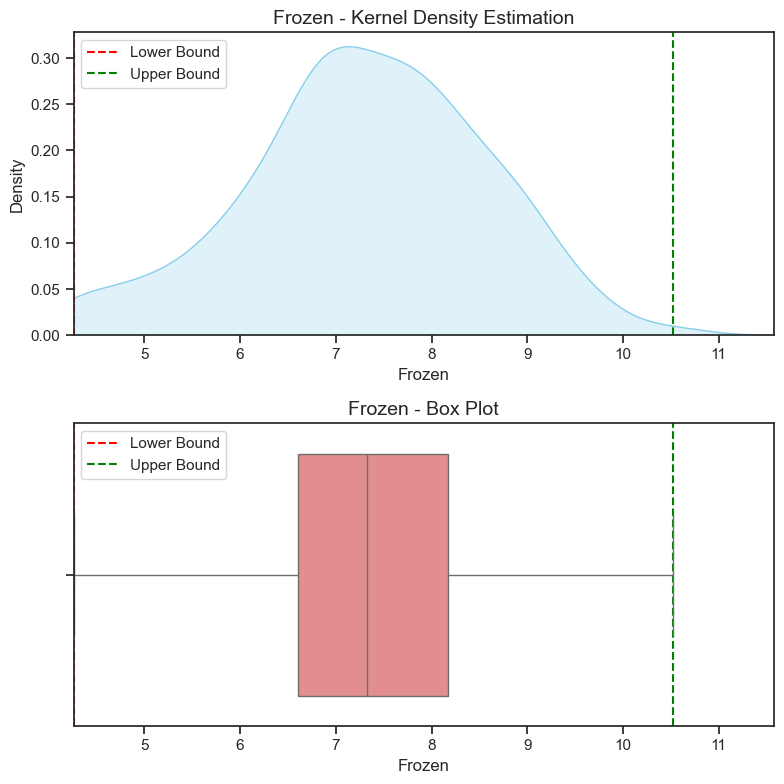

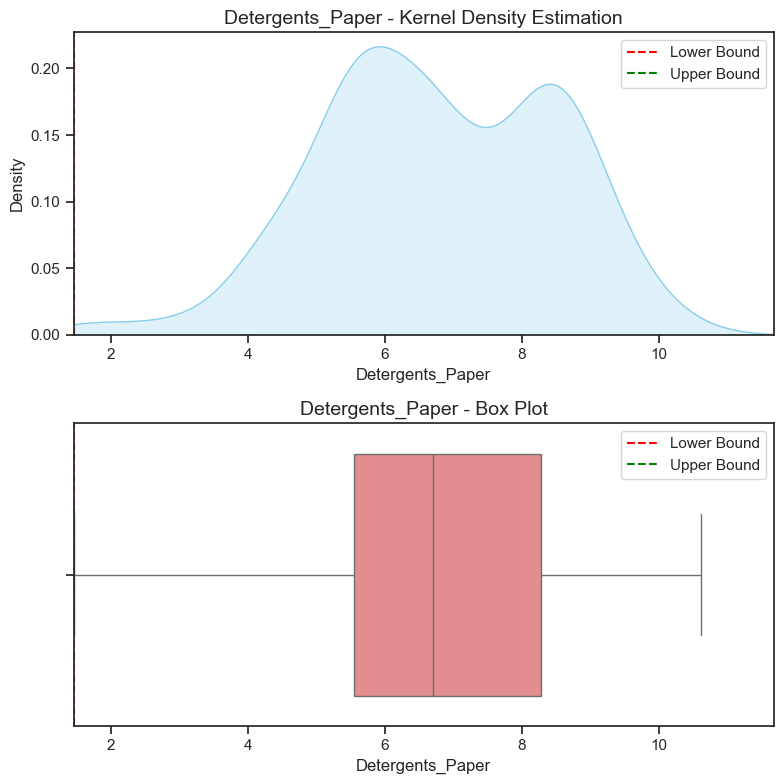

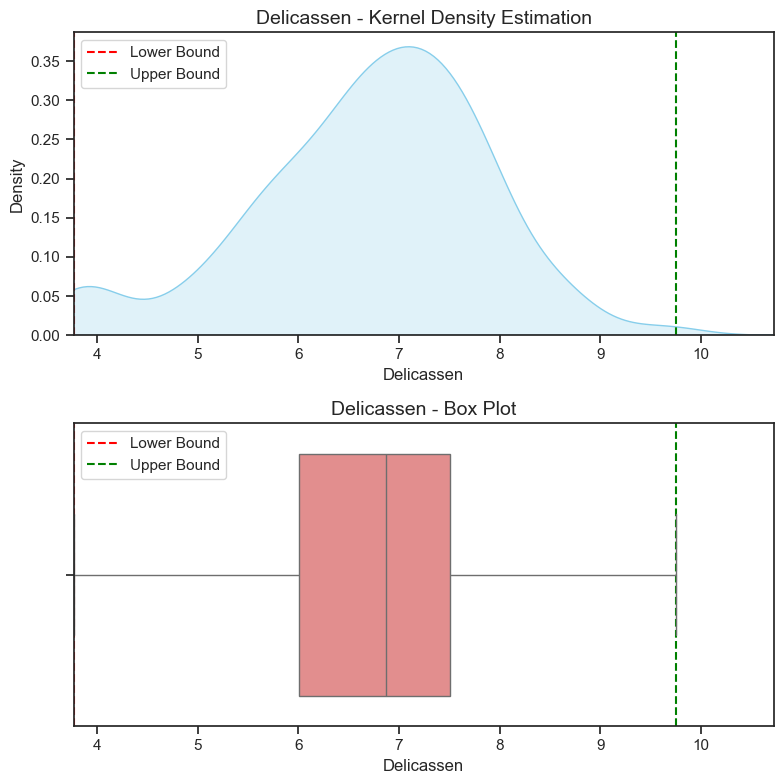

In [32]:
for i in df.keys():
    q25, q75 = np.percentile(df[i], [25, 75])
    iqr = q75 - q25
    lower_bound = q25 - iqr * 1.5
    upper_bound = q75 + iqr * 1.5

    plt.figure(figsize=(8, 8))

    plt.subplot(211)
    plt.xlim(df[i].min(), df[i].max() * 1.1)
    plt.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axvline(x=upper_bound, color='green', linestyle='--', label='Upper Bound')
    sns.kdeplot(data=df[i], fill=True, color='skyblue')
    plt.legend()
    plt.title(f'{i} - Kernel Density Estimation', fontsize=14)
    
    plt.subplot(212)
    plt.xlim(df[i].min(), df[i].max() * 1.1)
    plt.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axvline(x=upper_bound, color='green', linestyle='--', label='Upper Bound')
    sns.boxplot(x=df[i], color='lightcoral')
    plt.legend()
    plt.title(f'{i} - Box Plot', fontsize=14)
    
    plt.tight_layout() 
    plt.show()

In [33]:
for i in df.keys():
    q25, q75 = np.percentile(df[i], [25,75])
    iqr = q75 - q25
    
    lower_bound = q25 - iqr*1.5
    upper_bound = q75 + iqr*1.5
    
    df.loc[df[i] < lower_bound, i] = lower_bound
    df.loc[df[i] > upper_bound, i] = upper_bound

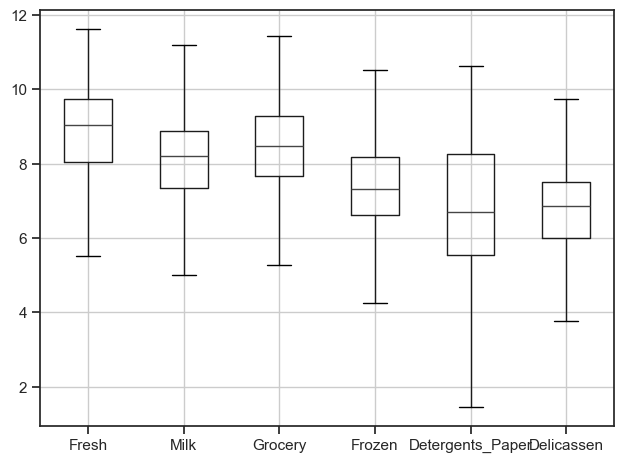

In [34]:
df.boxplot()
plt.tight_layout()
plt.show()

In [35]:
df.isnull().sum()

Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [36]:
df.duplicated().sum()

0

## Standardization

Karena kita akan melakukan pengelompokan, jarak antar nilai menjadi penting. Dalam konteks ini, standarisasi data dapat mengurangi dampak unit atau rentang nilai yang digunakan untuk mengukur variabel.

In [37]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

# 🧠 Model

## Clustering

Pada algoritma K-means, jumlah cluster harus ditentukan terlebih dahulu. Dalam konteks ini, untuk menentukan jumlah cluster yang sesuai, kita akan menggambar dendrogram menggunakan metode hierarki. Dengan dendrogram, secara intuitif kita dapat melihat jumlah cluster yang sesuai.

Untuk membuat struktur homogen satu sama lain dan struktur heterogen dengan kelompok lain, kita akan menggunakan metode pengelompokan non-hierarki.

### Dendogram

Karena variabel dalam dataset terdiri dari data numerik (tidak termasuk data kategorikal), maka kita akan menggunakan jarak Euclidean.


In [38]:
euclidean_distances = pdist(df, metric='euclidean')
cluster_hierarchy = linkage(euclidean_distances, method='average')
coph_corr, coph_dist = cophenet(cluster_hierarchy, euclidean_distances)
observation_names = np.arange(0, df.shape[0]).tolist()

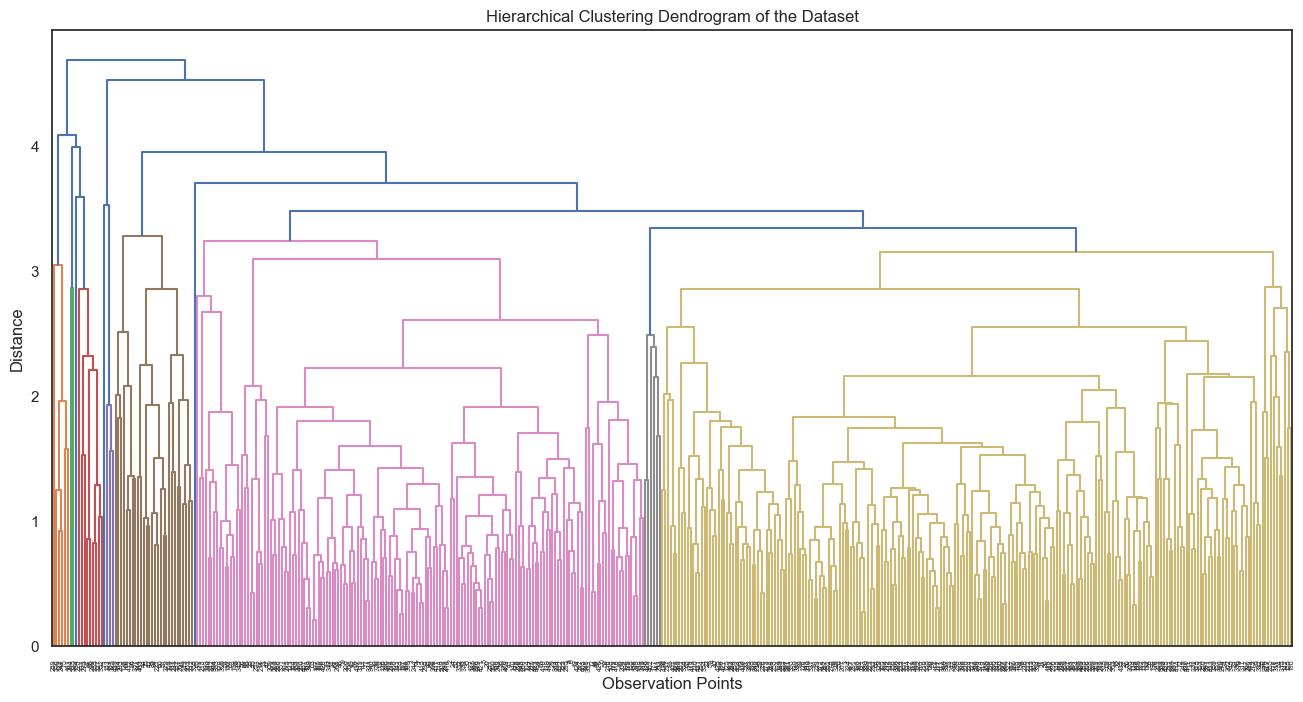

In [39]:
sns.set()
sns.set_style('white')
plt.figure(figsize=(16, 8))
dendrogram(cluster_hierarchy, labels=observation_names)
plt.title('Hierarchical Clustering Dendrogram of the Dataset')
plt.xlabel('Observation Points')
plt.ylabel('Distance')
plt.show()

**Looking at the dendrogram graph, we decide that it would be appropriate to determine 6 clusters.**

In [40]:
print(f'Cophenetic Correlation Coefficient: {coph_corr}')

Cophenetic Correlation Coefficient: 0.6448497671919403


**When looking at the Cophenetic Correlation Coefficient (CCC) value, we can see that the dendrogram moderately reflects similarities in the dataset.**


## K-Means

In [42]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(df)
labels = kmeans.labels_

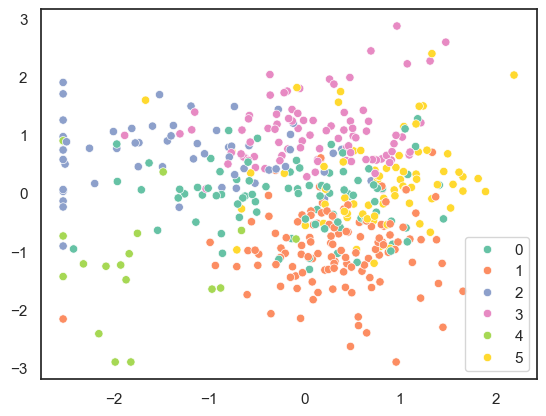

In [43]:
sns.scatterplot(x=df[:, 0], y=df[:, 1], hue=labels, palette='Set2')
plt.show()

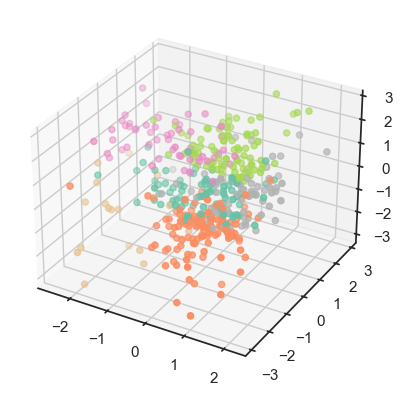

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[:, 0], df[:, 1], df[:, 2], c=labels, cmap='Set2')
plt.show()

## DBSCAN

In [45]:
dbscan = DBSCAN(eps=1)
dbscan.fit(df)
labels_dbscan = dbscan.labels_

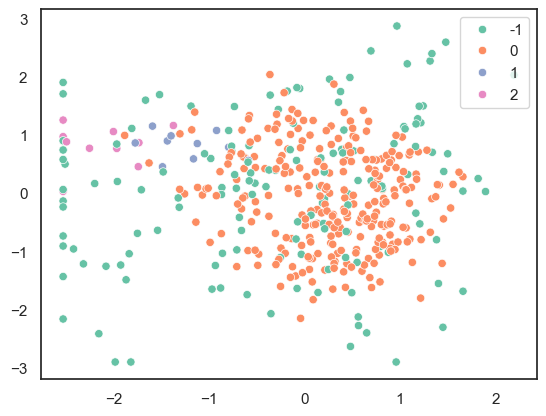

In [46]:
sns.scatterplot(x=df[:, 0], y=df[:, 1], hue=labels_dbscan, palette='Set2')
plt.show()

## Gaussian Mixture

In [47]:
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(df)
labels_gmm = gmm.predict(df)
centers_gmm = gmm.means_
n_clusters = len(centers_gmm)

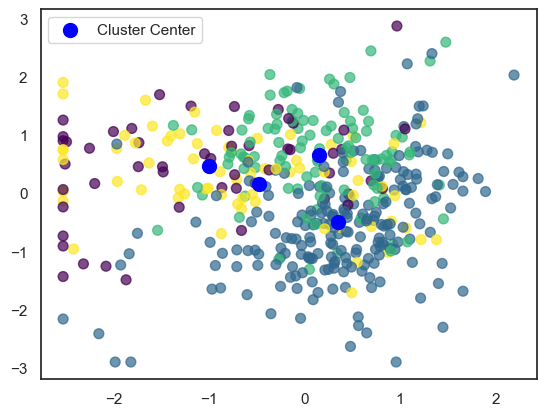

In [48]:
plt.scatter(df[:, 0], df[:, 1], c=labels_gmm, cmap='viridis', s=50, alpha=0.7)
plt.scatter(centers_gmm[:, 0], centers_gmm[:, 1], c='blue', s=100, marker='o', label='Cluster Center')
plt.legend()
plt.show()

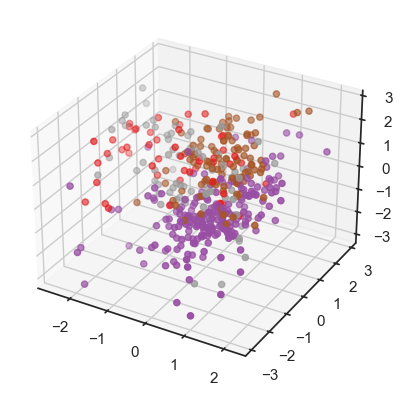

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[:, 0], df[:, 1], df[:, 2], c=labels_gmm, cmap='Set1')
plt.show()

## PCA

In [50]:
model = PCA(n_components=2)
pca_df = model.fit_transform(df)
model = KMeans(n_clusters=6)
model.fit(pca_df)
prediction2 = model.predict(pca_df)

In [51]:
prediction2.shape

(440,)

In [52]:
centers = model.cluster_centers_
centers

array([[-1.67123343,  1.83845356],
       [ 1.95561043,  2.6785038 ],
       [-1.90650466, -0.53564952],
       [ 1.89109732, -0.11110991],
       [ 0.22340397,  0.36110787],
       [ 0.2802816 , -1.60631939]])

In [53]:
prediction_0 = prediction2 == 0
prediction_1 = prediction2 == 1

In [54]:
x_0 = pca_df[prediction_0, 0]
y_0 = pca_df[prediction_0, 1]
x_1 = pca_df[prediction_1, 0]
y_1 = pca_df[prediction_1, 1]

In [55]:
center_x_0 = centers[0,0]
center_y_0 = centers[0,1]
center_x_1 = centers[1,0]
center_y_1 = centers[1,1]

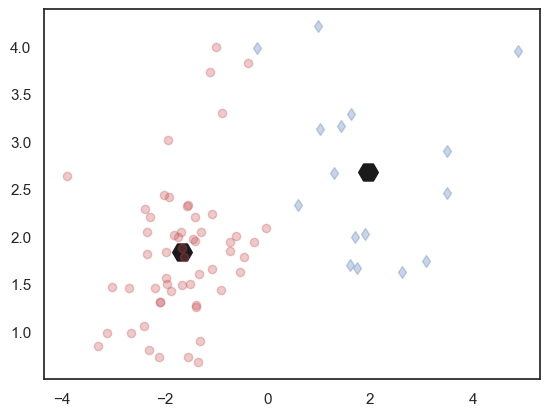

In [56]:
plt.plot(x_0, y_0, 'ro', alpha=0.3)
plt.plot(x_1, y_1, 'bd', alpha=0.3)
plt.scatter(center_x_0, center_y_0, marker='H', s=200, c='k')
plt.scatter(center_x_1, center_y_1, marker='H', s=200, c='k')
plt.show()